In [1]:
import numpy as np
import pandas as pd
from keras.models import *
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from datetime import datetime
import time
import sys
import configparser
import json
import pickle

import matplotlib.pyplot as plt
#%matplotlib inline

from unet.generator import *
from unet.loss import *
from unet.maskprocessor import *
from unet.visualization import *
from unet.modelfactory import *

os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

Using TensorFlow backend.


This notebook trains the Road Segmentation model.  The exported .py script takes in the config filename via a command line parameter.  To run this notebook directly in jupyter notebook, please manually set config_file to point to a configuration file (e.g. cfg/default.cfg).

In [2]:
# command line args processing "python RoadSegmentor.py cfg/your_config.cfg"
if len(sys.argv) > 1 and '.cfg' in sys.argv[1]:
    config_file = sys.argv[1]
else:
    config_file = 'cfg/default.cfg'
    #print('missing argument. please provide config file as argument. syntax: python RoadSegmentor.py <config_file>')
    #exit(0)

print('reading configurations from config file: {}'.format(config_file))

settings = configparser.ConfigParser()
settings.read(config_file)

x_data_dir = settings.get('data', 'train_x_dir')
y_data_dir = settings.get('data', 'train_y_dir')
print('x_data_dir: {}'.format(x_data_dir))
print('y_data_dir: {}'.format(y_data_dir))

data_csv_path = settings.get('data', 'train_list_csv')

print('model configuration options:', settings.options("model"))

model_dir = settings.get('model', 'model_dir')
print('model_dir: {}'.format(model_dir))

timestr = time.strftime("%Y%m%d-%H%M%S")

model_id = settings.get('model', 'id')
print('model: {}'.format(model_id))

optimizer_label = 'Adam' # default

if settings.has_option('model', 'optimizer'):
    optimizer_label = settings.get('model', 'optimizer')
    
if settings.has_option('model', 'source'):
    model_file = settings.get('model', 'source')
    print('model_file: {}'.format(model_file))
else:
    model_file = None

learning_rate = settings.getfloat('model', 'learning_rate')
max_number_epoch = settings.getint('model', 'max_epoch')
print('learning rate: {}'.format(learning_rate))
print('max epoch: {}'.format(max_number_epoch))

min_learning_rate = 0.000001
if settings.has_option('model', 'min_learning_rate'):
    min_learning_rate = settings.getfloat('model', 'min_learning_rate')
print('minimum learning rate: {}'.format(min_learning_rate))

lr_reduction_factor = 0.1
if settings.has_option('model', 'lr_reduction_factor'):
    lr_reduction_factor = settings.getfloat('model', 'lr_reduction_factor')
print('lr_reduction_factor: {}'.format(lr_reduction_factor))

batch_size = settings.getint('model', 'batch_size') 
print('batch size: {}'.format(batch_size))

input_width = settings.getint('model', 'input_width')
input_height = settings.getint('model', 'input_height')

reading configurations from config file: cfg/default.cfg
x_data_dir: /media/rick/7B3A33754CA4427C/codefundo_code/train/
y_data_dir: /media/rick/7B3A33754CA4427C/codefundo_code/label/
model configuration options: ['id', 'optimizer', 'learning_rate', 'min_learning_rate', 'lr_reduction_factor', 'max_epoch', 'batch_size', 'model_dir', 'input_width', 'input_height']
model_dir: model/
model: Dilated_Unet
learning rate: 0.0001
max epoch: 32
minimum learning rate: 1e-07
lr_reduction_factor: 0.2
batch size: 1


In [3]:
img_gen = CustomImgGenerator(x_data_dir, y_data_dir, data_csv_path)

train_gen = img_gen.trainGen(batch_size=batch_size, is_Validation=False)

validation_gen = img_gen.trainGen(batch_size=batch_size, is_Validation=True)

In [4]:
timestr = time.strftime("%Y%m%d-%H%M%S")
model_filename = model_dir + '{}-{}.hdf5'.format(model_id, timestr)
print('model checkpoint file path: {}'.format(model_filename))

# Early stopping prevents overfitting on training data
# Make sure the patience value for EarlyStopping > patience value for ReduceLROnPlateau. 
# Otherwise ReduceLROnPlateau will never be called.
early_stop = EarlyStopping(monitor='val_loss',
                           patience=100,
                           min_delta=0, 
                           verbose=1,
                           mode='auto')

model_checkpoint = ModelCheckpoint(model_filename,
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True)

reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=lr_reduction_factor,
                             patience=2,
                             verbose=1,
                             min_lr=min_learning_rate,
                             epsilon=1e-4)

model checkpoint file path: model/Dilated_Unet-20181022-013947.hdf5


/home/rick/.local/lib/python3.5/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [5]:
training_start_time = datetime.now()

number_validations = img_gen.validation_samples_count()

samples_per_epoch = img_gen.training_samples_count()

modelFactory = ModelFactory(num_channels = 3, 
                            img_rows = input_height,
                            img_cols = input_width)

if model_file is not None:
    model = load_model(model_dir + model_file,
                  custom_objects={'dice_coef_loss': dice_coef_loss, 
                                  'dice_coef': dice_coef, 
                                  'binary_crossentropy_dice_loss': binary_crossentropy_dice_loss})
else:
    model = modelFactory.get_model(model_id)

print(model.summary())

if optimizer_label == 'Adam':
    optimizer = Adam(lr = learning_rate)
elif optimizer_label == 'RMSprop':
    optimizer = RMSprop(lr = learning_rate)
else:
    raise ValueError('unsupported optimizer: {}'.format(optimizer_label))

model.compile(optimizer = optimizer,
              loss = dice_coef_loss,
              metrics = ['accuracy', dice_coef])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 512, 512, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 9248        activation_1[0][0]               
__________________________________________________________________________________________________
activation

In [6]:
batch_size = 1
history = model.fit_generator(generator=train_gen,
                              steps_per_epoch=np.ceil(float(samples_per_epoch) / float(batch_size)),
                              validation_data=validation_gen,
                              validation_steps=np.ceil(float(number_validations) / float(batch_size)),
                              epochs=max_number_epoch,
                              verbose=1,
                              callbacks=[model_checkpoint, early_stop, reduceLR])
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")
time_spent_trianing = datetime.now() - training_start_time
print('model training complete. time spent: {}'.format(time_spent_trianing))

Epoch 1/32
2874/2874 [==============================] - 238s 83ms/step - loss: -0.2092 - acc: 0.8953 - dice_coef: 0.2092 - val_loss: -0.3205 - val_acc: 0.9500 - val_dice_coef: 0.3205

Epoch 00001: val_loss improved from inf to -0.32048, saving model to model/Dilated_Unet-20181022-013947.hdf5
Epoch 2/32
2874/2874 [==============================] - 235s 82ms/step - loss: -0.3486 - acc: 0.9573 - dice_coef: 0.3486 - val_loss: -0.4094 - val_acc: 0.9603 - val_dice_coef: 0.4094

Epoch 00002: val_loss improved from -0.32048 to -0.40944, saving model to model/Dilated_Unet-20181022-013947.hdf5
Epoch 3/32
2874/2874 [==============================] - 235s 82ms/step - loss: -0.3824 - acc: 0.9588 - dice_coef: 0.3824 - val_loss: -0.4390 - val_acc: 0.9628 - val_dice_coef: 0.4390

Epoch 00003: val_loss improved from -0.40944 to -0.43897, saving model to model/Dilated_Unet-20181022-013947.hdf5
Epoch 4/32
2874/2874 [==============================] - 235s 82ms/step - loss: -0.3951 - acc: 0.9591 - dice_coe

2874/2874 [==============================] - 235s 82ms/step - loss: -0.4506 - acc: 0.9637 - dice_coef: 0.4506 - val_loss: -0.4676 - val_acc: 0.9645 - val_dice_coef: 0.4676

Epoch 00030: val_loss did not improve from -0.47124
Epoch 31/32
2874/2874 [==============================] - 235s 82ms/step - loss: -0.4498 - acc: 0.9637 - dice_coef: 0.4498 - val_loss: -0.4674 - val_acc: 0.9645 - val_dice_coef: 0.4674

Epoch 00031: val_loss did not improve from -0.47124

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 32/32
2874/2874 [==============================] - 235s 82ms/step - loss: -0.4495 - acc: 0.9638 - dice_coef: 0.4495 - val_loss: -0.4677 - val_acc: 0.9646 - val_dice_coef: 0.4677

Epoch 00032: val_loss did not improve from -0.47124
Saved model to disk
model training complete. time spent: 2:05:40.595096


{'loss': [-0.2091650898172656, -0.3486003662788687, -0.38238469891310445, -0.3951105795028209, -0.40492229492787324, -0.4258997426564347, -0.43132771374604284, -0.4321684262040606, -0.435179108954712, -0.4372918834193968, -0.4381474786649977, -0.4396270561105233, -0.44058737024893657, -0.44592196570892884, -0.4474363618387103, -0.4478614966716571, -0.4485863073858629, -0.4484163550926951, -0.4490092921909601, -0.44956565796823833, -0.4504775289809377, -0.4501253605439823, -0.4504651039279352, -0.45063427616913027, -0.4496400945351823, -0.4493605539496397, -0.45022803062340405, -0.45063463990591474, -0.4506497188424594, -0.45061636070917044, -0.44982044400728943, -0.44951964244823295], 'val_acc': [0.9500234548173462, 0.9603481849808355, 0.9628172597235201, 0.9626775165923945, 0.9628351076256085, 0.9620621512761866, 0.9632482992922978, 0.9635320989744056, 0.9635192223815493, 0.9626898838515408, 0.9646436136853214, 0.9637519666647878, 0.9646491951338937, 0.9642198851775062, 0.964960403336

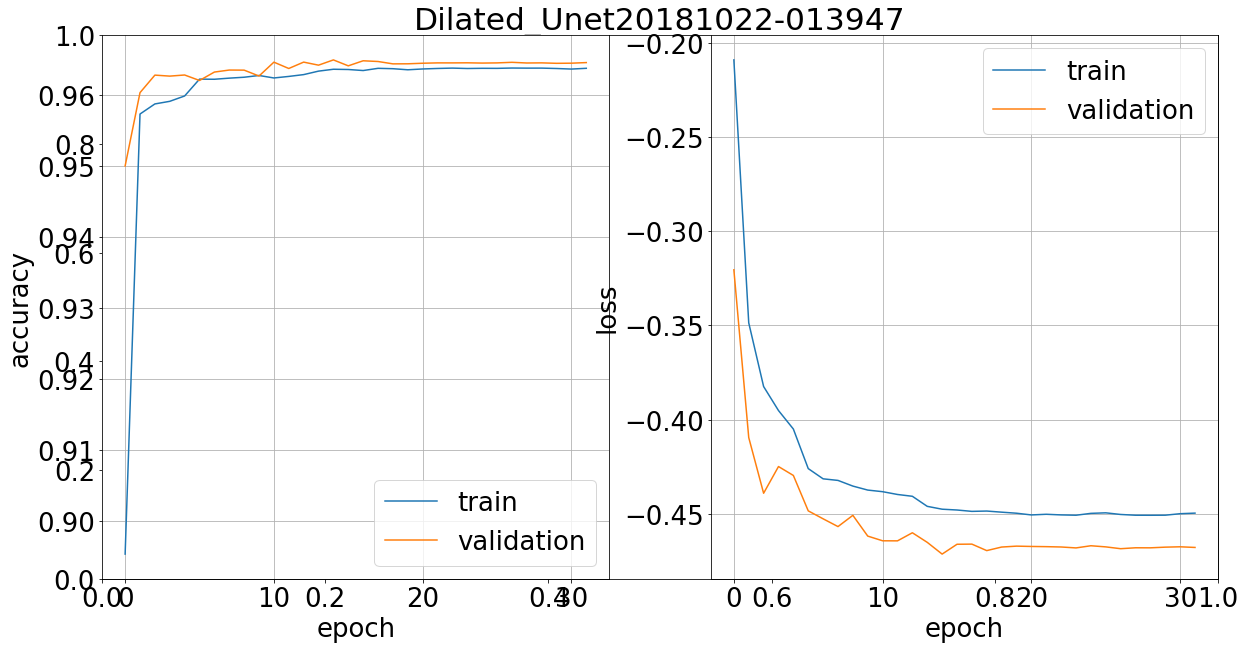

In [7]:
print(history.history)

historyFilePath = model_dir + '{}-{}-train-history.png'.format(model_id, timestr)
trainingHistoryPlot(model_id + timestr, historyFilePath, history.history)

pickleFilePath = model_dir + '{}-{}-history-dict.pickle'.format(model_id, timestr)
with open(pickleFilePath, 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/32
7999/7999 [==============================] - 663s 83ms/step - loss: -0.3871 - acc: 0.9770 - dice_coef: 0.3871 - val_loss: -0.3929 - val_acc: 0.9886 - val_dice_coef: 0.3929

Epoch 00001: val_loss improved from inf to -0.39292, saving model to model/Dilated_Unet-20181021-010553.hdf5
Epoch 2/32
7999/7999 [==============================] - 659s 82ms/step - loss: -0.3928 - acc: 0.9886 - dice_coef: 0.3928 - val_loss: -0.3929 - val_acc: 0.9886 - val_dice_coef: 0.3929

Epoch 00002: val_loss did not improve from -0.39292
Epoch 3/32
7999/7999 [==============================] - 659s 82ms/step - loss: -0.3931 - acc: 0.9885 - dice_coef: 0.3931 - val_loss: -0.3929 - val_acc: 0.9886 - val_dice_coef: 0.3929

Epoch 00003: val_loss did not improve from -0.39292

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 4/32
7999/7999 [==============================] - 659s 82ms/step - loss: -0.3926 - acc: 0.9885 - dice_coef: 0.3926 - val_loss: -0.3929 - val_acc: 0.9886 - val_dice_coef: 0.3929

Epoch 00004: val_loss did not improve from -0.39292
Epoch 00004: early stopping
Saved model to disk
model training complete. time spent: 0:44:05.079761